In [2]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from matplotlib import pyplot as plt

### Activation Functions

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def elu(z, alpha: float):
    return alpha * (np.exp(z) - 1) if z < 0 else z

### Trial Solution

In [24]:
def trial_solution(
    input: np.array, parameters: list, initial_conditions: np.array
) -> np.array:
    fp = forward_propogation(input, parameters)
    return  [input * fp[0], 1 + input * fp[1]]

def right_hand_side(
    input: np.array, trial_sol: np.array, constants: np.array
) -> np.array:
    return np.array(
        [
            np.cos(input) + trial_sol[0]**2 + trial_sol[1] - (1 + input**2 + np.sin(input)**2),
            2 * input - (1 - input**2) * np.sin(input) + trial_sol[0] * trial_sol[1]
        ]
    )

### Loss Function

In [25]:
def MSE_loss_function(
    input, parameters: list, constants: np.array, initial_conditions: np.array
):
    trial_sol = trial_solution(input, parameters, initial_conditions)
    prediction = right_hand_side(input, trial_sol, constants)
    neural_network_gradient = elementwise_grad(trial_solution, 0)(
        input, parameters, initial_conditions
    )

    error_squared = (neural_network_gradient - prediction) ** 2
    loss_sum_mean = np.sum(error_squared / np.shape(error_squared)[1])

    return loss_sum_mean

### Neural Network

![](NN.png "Neural Network")

In [6]:
def init_parameters(input_size: int, hidden_sizes: np.array, output_size: int):
    parameters = [None] * (hidden_sizes.shape[0] + 1) # +1 for the output

    # hidden weights and biases
    parameters[0] = np.random.randn(hidden_sizes[0], input_size + 1) # +1 for the bias
    for i in range(1, hidden_sizes.shape[0]):
        parameters[i] = np.random.randn(hidden_sizes[i], hidden_sizes[i - 1] + 1) # +1 for the bias

    # output weights and biases
    parameters[-1] = np.random.randn(output_size, hidden_sizes[-1] + 1) # +1 for the bias

    return parameters

In [7]:
def forward_propogation(input: np.array, parameters: list):
    num_hidden_layers = len(parameters) - 1
    num_inputs = input.size
    input = input.reshape(-1, input.size)

    # hidden layers
    z = np.matmul(parameters[0], np.concatenate((np.ones((1, num_inputs)), input), axis = 0))
    a = sigmoid(z)
    for i in range(1, num_hidden_layers):
        z = np.matmul(parameters[i], np.concatenate((np.ones((1, num_inputs)), a), axis = 0))
        a = sigmoid(z)

    # output layer
    z = np.matmul(parameters[-1], np.concatenate((np.ones((1, num_inputs)), a), axis = 0))
    
    return z

In [21]:
def adam(input, parameters, constants, initial_conditions, grad, num_iters=30000,
         step_size=0.01, b1=0.9, b2=0.999, eps=10**-8):
    m = [np.zeros_like(parameters[i]) for i in range(len(parameters))]
    v = [np.zeros_like(parameters[i]) for i in range(len(parameters))]
    mhat = [None] * len(parameters)
    vhat = [None] * len(parameters)
    for i in range(num_iters):
        g = grad(input, parameters, constants, initial_conditions)
        print("iteration: ", i)
        print(MSE_loss_function(input, parameters, constants, initial_conditions))
        
        for j in range(len(parameters)):
            m[j] = (1 - b1) * g[j]      + b1 * m[j]  # First  moment estimate.
            v[j] = (1 - b2) * (g[j]**2) + b2 * v[j]  # Second moment estimate.
            mhat[j] = m[j] / (1 - b1**(i + 1))    # Bias correction.
            vhat[j] = v[j] / (1 - b2**(i + 1))
            parameters[j] = parameters[j] - step_size * mhat[j]/(np.sqrt(vhat[j]) + eps)
    
    return parameters

In [32]:
t = np.arange(0, 2, 0.001)
constants = np.array([2])
initial_conditions = np.array([10])
parameters = init_parameters(1, np.array([10]), 2)

loss_grad_function = grad(MSE_loss_function, 1)
parameters = adam(t, parameters, constants, initial_conditions, loss_grad_function)

res = trial_solution(t, parameters, initial_conditions)

iteration:  0
515.4651972486396
iteration:  1
456.72026564419724
iteration:  2
403.385547364835
iteration:  3
355.15584220251117
iteration:  4
311.70179784290036
iteration:  5
272.6853358917548
iteration:  6
237.7698918031024
iteration:  7
206.63331731108434
iteration:  8
178.972761703677
iteration:  9
154.50224989428696
iteration:  10
132.9481430528889
iteration:  11
114.04621576536233
iteration:  12
97.54116931315913
iteration:  13
83.18789371159251
iteration:  14
70.75354564261542
iteration:  15
60.0197150470635
iteration:  16
50.7842066875026
iteration:  17
42.86217632911085
iteration:  18
36.08653788033486
iteration:  19
30.307696855113942
iteration:  20
25.392754252791907
iteration:  21
21.224358179397022
iteration:  22
17.699369044319297
iteration:  23
14.727468069765562
iteration:  24
12.229796810418588
iteration:  25
10.137678813971846
iteration:  26
8.39144768551766
iteration:  27
6.939388402250439
iteration:  28
5.736788684269214
iteration:  29
4.745092250966554
iteration:  

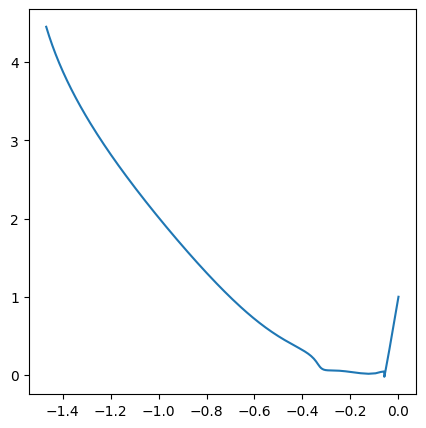

In [30]:
res = trial_solution(t, parameters, initial_conditions)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.plot(res[0], res[1])

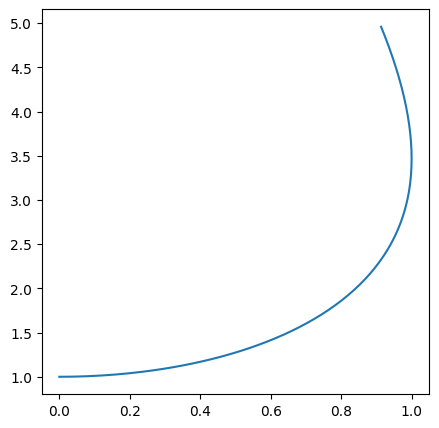

In [31]:
def analytic(input):
    return [np.sin(input), 1 + t**2]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.plot(analytic(t)[0], analytic(t)[1])